# Reinforcement Learning Lecture

## 1. Learning Agents

- The agent repeatedly takes **action** $a_t \in \mathbb{A}$ in discrete time periods, $t \in \mathbb{N}.$
- When the agent choose action $a_t$ at time $t$, it obtaints an immediate **observable reward**, $r_{t+1}$.
- The **return** $G_t$ at time $t$ is some function $f$ of the future rewards $G_t= f(r_{t+1} , r_{t+2},\cdots)$.
- Often we use $G_t = \sum_{i=t}^{\infty} \gamma^i r_{i+1}$, where $\gamma \ in [0,1]$ is the **time discounting** of the agent.

## 2. Markov Decision Processes
- The reward is a function of the action chosen in the previous state $s_t \in \mathbb{S}$.
- The $s$ state and action $a$ at time $t$ determines the probability of the subsequent state s ′ and reward $r$.
- The probabilities are specified by the function $p(s',r|s,a)$.
- This specifies a finite **Markov Decision-Process**.
- The goal of the agent is to maximise the expected return $\mathbb{E}(G)$.
- The agent follows a **policy** which specifies an action to take in each state: $\pi(s)\in\mathbb{A}$.
- The optimal policy is denoted $\pi^*$ .

## 3. Value Functions

We use the function $v(a)$ to denote the expected return for action a over the entire episode:

$$\begin{equation}\begin{split}
v(a) &= \mathbb{E}(G|a_t = a,  \forall_t) \\
&= \mathbb{E}(R_{a})
\end{split}\end{equation}
$$

- Typically, the function $v$ is unknown to the agent.
- In this scenario, the agent performs *sequential decision making under uncertainty*.

---

Consider an $n$-armed bandit where $R_a \sim \mathcal{N} (a, 1)$, i.e. the bandit's output is a random variable with **mean** $a$, and **variance** $1$.

In [2]:
import numpy as np


def play_bandit(a, variance=1.0):
    """ Return the reward from taking action a """
    return np.random.normal(a, scale=np.sqrt(variance))


At $t = 1$, suppose we choose action $a = 1$, we then obtain realised reward $r_2$:

In [3]:
r_2 = play_bandit(a=1)
r_2

-0.10393426889284396

Let's play some more...

In [5]:
play_bandit(a=1)

-0.5543168494171886

In [6]:
play_bandit(a=1)

-2.781620637641941

In [7]:
play_bandit(a=1)

0.027760893809585685

In [8]:
play_bandit(a=1)

1.6442640175839665

In [9]:
play_bandit(a=1)

0.8703354688262152

## 4. Greedy Action

If we can compute $v(a)$, then the agent's optimal policy is simple. That is the agent simply choose the action with the highest expection.

$$a^* = arg\max_{a} v(a)$$

- we call $a^*$ as the **greedy action**.

## 5. Learning as Sampling

The random variates, $r_t$, are directly observable.
They are samples from the distribution $F_{a}(r)$.

$$r_t \sim^{distribution} F_{a}(r)$$

How can we estimate $v(\alpha)$ given the observed rewards $r_1,r_2, ..., r_t$?

## 6. Value Estimation
We can use the *sampling to estimate* $v(.)$,

$$Q_r(a) = \frac{r_1+r_2+...+r_k}{k}$$

- By the law of large numbers,

$$ \lim_{k\to\infty}Q(a) = v(a) $$

In [10]:
def sample_from_bandit(a, k):
    rewards = []
    for t in range(k):
        r = play_bandit(a)
        rewards.append(r)
    return np.mean(rewards)

Sample $k=20$ times using action $a=2$ (should be close to 2):

In [11]:
q_2 = sample_from_bandit(a=2, k=20)
q_2

2.0938313683905614

Executing more samples, $k=10000$, sample mean should converge to the true expectation of 2:

In [15]:
q_2 = sample_from_bandit(a=2, k=10000)
q_2

1.9914171679872692

Improve code by vectorizing code instead of looping (better for `tensorflow`):

In [17]:
def sample_from_bandit(a, k):
    # using map: return np.mean(map(lambda i: play_bandit(a), range(k)))
    return np.mean([play_bandit(a) for t in range(k)])  # using list comprehension

In [19]:
q_2 = sample_from_bandit(a=2, k=10000)  # using updated list comprehension code
q_2

1.9903265017514138

Improve code even more by 1.19, incremental updates of our sampling mean
$$Q_k=\frac{r_1+...+r_k}{k}=Q_{k-1}+\frac{1}{k}(r_{k-1}-Q_{k-1}):$$


## 7. Incremental update of estimates

$$\begin{equation}
\begin{split}
Q_{k} & = \frac{1}{k} \sum_{i=1}^k r_i \\
& = \frac{1}{k}(r_k + \sum_{i=1}^{k-1} r_i) \\
& = \frac{1}{k}[r_k + (k-1) \frac{1}{k-1}\sum_{i=1}^{k-1} r_i] \\
& = \frac{1}{k}[r_k + (k-1)Q_{k-1}] \\
& = \frac{1}{k}[r_k + k\cdot Q_{k-1} - Q_{k-1}] \\
& = Q_{k-1} + \frac{1}{k}[r_k - Q_{k-1}] 
\end{split}
\end{equation}$$

What does it implicate? It implicates that the next period estimate is equal to (1) a previous preiod estimate plus (2) a difference with a step size '1/k'.

### 7.1 Temporal Difference Learning
- We are adjusting/updating an old estimate towards a new estimate based on more recent information.
- We can think of the coefficient $(k)^{−1}$ as a step size parameter.
$$\begin{equation}\begin{split}
Q_{k+1} &= Q_k+\frac{1}{k} [r_k - Q_k] 
&= \sum_{k=1}^{N+1} \frac{1}{k} [r_k - Q_k]
\end{split}\end{equation}$$

`new_estimate = old_estimate + step_size * (target - old_estimate)`

#### Incremental Updates in Python

In [1]:
def update_q(old_estimate, target_estimate, k):
    step_size = 1./(k+1)
    error = target_estimate - old_estimate  # r_k - Q_k
    return old_estimate + step_size * error


def sample_from_bandit(a, k):
    current_estimate = 0.
    for t in range(k):
        current_estimate = update_q(current_estimate, play_bandit(a), t)
    return current_estimate

In [21]:
q_2 = sample_from_bandit(a=2, k=100000)
q_2

2.002542352207071

### 7.2 Using a Constant Step Size

Recall that with our previous update rule, the step_size parameter varies with each update.

$$Q_{k+1} = \frac{1}{k}[r_k-Q_k]$$

Alternatively, we can use a constant step size $\alpha \in [0,1]$

$$Q_{k+1} =Q_k + \alpha [r_k - Q_k] $$

## 8. Exponential Moving-average of Rewards

$$
\begin{equation} \begin{split}
Q_{k+1} &= Q_k + \alpha [r_k - Q_k] \\
&= \alpha r_k + (1-\alpha) Q_k \\
&= \alpha r_k + (1-\alpha)[\alpha r_{k-1} + (1-\alpha)Q_{k-1}] \\
&= \alpha r_k + (1-\alpha)\alpha r_{k-1} + (1-\alpha)^2 \alpha Q_{k-1} \\
&= \alpha r_k + (1-\alpha)\alpha r_{k-1} + (1-\alpha)^2 \alpha Q_{k-1} + \cdots + (1-\alpha)^{k-1} \alpha Q_{1} + (1-\alpha)^{k} \alpha Q_{0}\\
&= (1-\alpha)^k Q_0 + \sum^k_{i=1} \alpha (1-\alpha)^{k-i} r_i
\end{split} \end{equation}
$$

## 9. Recency

- Thus we see that if we use **constant step-size parameter**, we are calculating an exponential (i.e. time-weighted) ***moving average***.
- The moving average is an estimate of the expected reward.
- The parameter $\alpha$ is sometimes called the ***recency***. (Note: $\alpha$, *alpha* denotes the ***recency***, the letter $a$ denotes the ***action***).
- This parameter is *not* learned, but instead *is chosen* by the scientist.
    - Parameters that are chosen but not learned are called *hyper-parameters*.

### Non-stationary environments
If the first moment of the reward distribution is **non-stationary**, then we should choose a larger values of $\alpha$.

Large $\alpha$ means large weights of the arbitary term, and goes close to the random walk.
_____

Recency $\alpha$ in Python following 1.22:

In [3]:
# updating with a chosen hyper-parameter recency, called alpha
def update_q(old_estimate, target_estimate, recency=0.2):
    error = target_estimate - old_estimate
    return old_estimate + recency * error

## 10. Action Selection

As discussed, if we have accurate estimates $Q(a) = v(a)$, then the optimal policy $\pi^*$ is straightforward:

$$a_t^* = arg\max_{a} Q_t(a)$$

The Optimal Policy is $a = a^*$ such that $a$ could maximise the estimate

However, is this the optimal policy if estimates are inaccurate?

### 10.1 Exploration
- Value forecasting and policy selection are not independent.
- If estimates $Q(a)$ are based on small sample sizes $k_a$ , and we always choose a non-representitive *greedy action*, then our policy will be sub-optimal.
- **Taking the greedy action is called *Exploitation***.
- In order to learn, our agent must also **explore** the environment by sampling from alternative actions.
- This is true even when current information suggests that the alternative are suboptimal;
- current information may be inaccurate.

In my personal understanding, there are steps to learn from the data evovlution.
**The first step is Exploration**. We may explore the action to see which action rewards more. **The second step is Exploitation**. We take the *greedy action*, by which we mean that we are about to take actions that give highest reward from the exploration phase.

### 10.2 Drawback of Exploration & Exploitation

There are some drawbacks of that structure like the above. For instance, if the exploration data-set is not large enough, or if the exploration results are not representative, then the exploitation phase would be misled.

### 10.3 $\epsilon$-greedy Exploration
**$\epsilon$-greedy exploration** to balance between exploration (probability $1-\epsilon$) + exploiting (probability $\epsilon$):

In [70]:
def explore(q):
    return np.random.randint(len(q))


def exploit(q):
    greedy_actions, = np.where(q == np.max(q))  # find the best action with highest expected return
    return np.random.choice(greedy_actions)  # break ties randomly if multiple actions are "best"


def act(q, epsilon=0.99):  # probability epsilon to exploit, otherwise explore
    if np.random.random() < epsilon:
        return exploit(q)
    else:
        return explore(q)

Concrete example with $\epsilon$-greedy exploration with $\epsilon=99\%$:

$n=20$-bandit problem with $5000$ rounds of playing...

In [59]:
def simulate_agent(n=20, T=5000, epsilon=0.99, variance=1.0):  # variance = how noisy is the bandit reward distribution
    q = np.zeros(n)
    actions = np.zeros(T); rewards = np.zeros(T)
    for t in range(T):  # at each time step...
        a = act(q, epsilon)
        reward = play_bandit(a, variance)
        q[a] = update_q(q[a], reward)
        actions[t] = a
        rewards[t] = reward
    return q, actions, rewards

## 11. The time series of actions $a_t$

From the below figure, we can find that most of the actions are the Xth, for which I may consider as the the Exploit behaviour. Other actions might be the Explore.

### 11.1 Action Distribution Plot

Run the below cell several times, you might find that the percentage of optimal action sometimes is significatnly lower than $\epsilon=99$%. That is due to the **non-representative exploration set**.

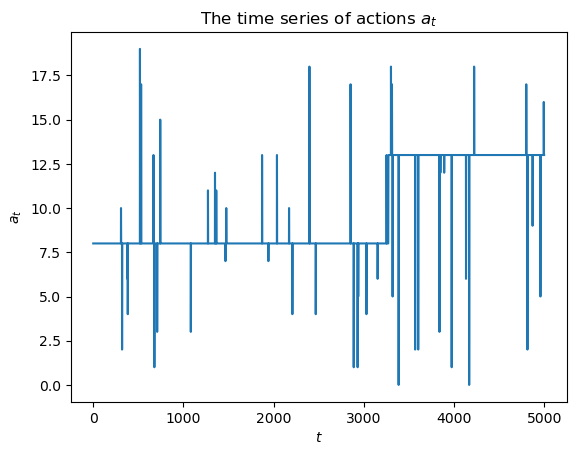

In [57]:
import matplotlib.pyplot as plt


q, actions, rewards = simulate_agent()
plt.plot(actions)
plt.xlabel('$t$')
plt.ylabel('$a_t$')
plt.title("The time series of actions $a_t$")
plt.show()

Most of the times seems to pick action 8 (lever 8) first, and then picking 13 after some time...

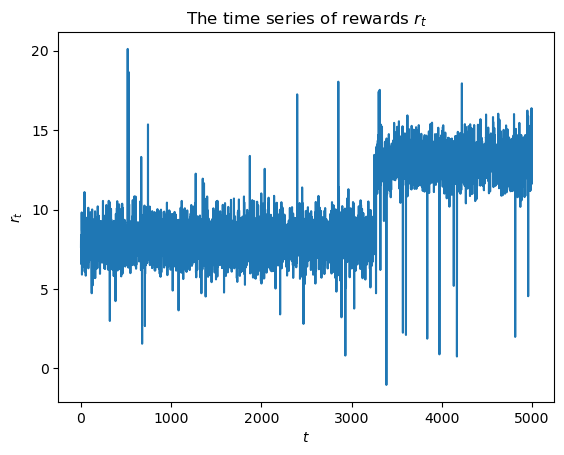

In [58]:
plt.plot(rewards)
plt.xlabel('$t$')
plt.ylabel('$r_t$')
plt.title("The time series of rewards $r_t$")
plt.show()

1.32 The expected reward + variance thereof

In [61]:
np.mean(rewards)

9.74793974323631

In [62]:
np.mean(rewards[4500:])

13.046197881920039

In [63]:
np.var(rewards[4500:])

1.3792571502694508

Increasing the exploration rate: Improve average reward (mean) but also introduce more risk (higher variance)...

In [88]:
q, actions, rewards = simulate_agent(epsilon=0.95)

In [89]:
np.mean(rewards[4500:])

17.54604681784477

In [90]:
np.var(rewards[4500:])

6.598442592278979

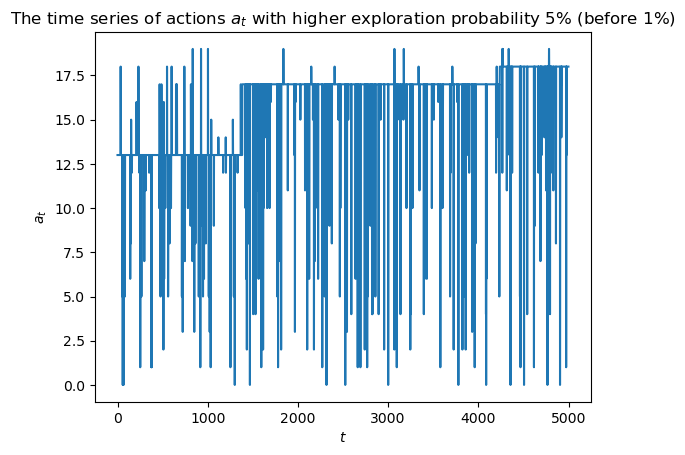

In [91]:
plt.plot(actions)
plt.xlabel('$t$')
plt.ylabel('$a_t$')
plt.title("The time series of actions $a_t$ with higher exploration probability 5% (before 1%)")
plt.show()

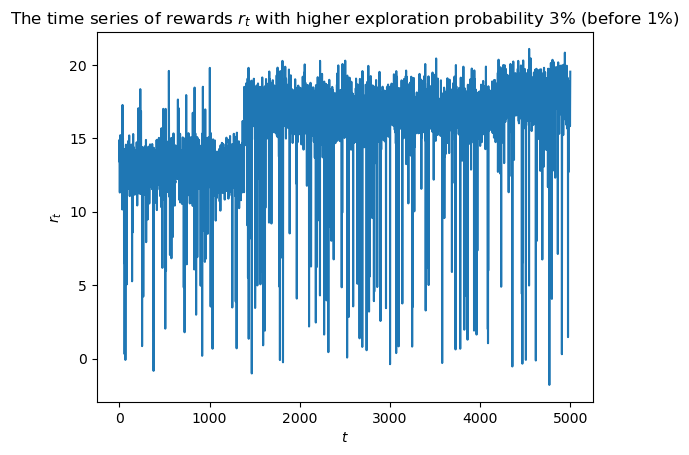

In [92]:
plt.plot(rewards)
plt.xlabel('$t$')
plt.ylabel('$r_t$')
plt.title("The time series of rewards $r_t$ with higher exploration probability 3% (before 1%)")
plt.show()

Introducing **Softmax exploration** with hyper-parameer $\tau$ called temperature.

* High values of $\tau\Rightarrow$ all actions nearly equiprobable.
* $\tau\rightarrow 0\Rightarrow$ greedy action selection (exploitation)
* Exploration is biased towards those actions with higher currently-estimated return.

In [36]:
def boltzmann(propensity, tau):
    return np.exp(propensity / tau)


def boltzmann_distribution(propensities, tau):
    x = np.array([boltzmann(p, tau) for p in propensities])
    total = np.sum(x)
    return x / total

1.42 Example $Q$ values

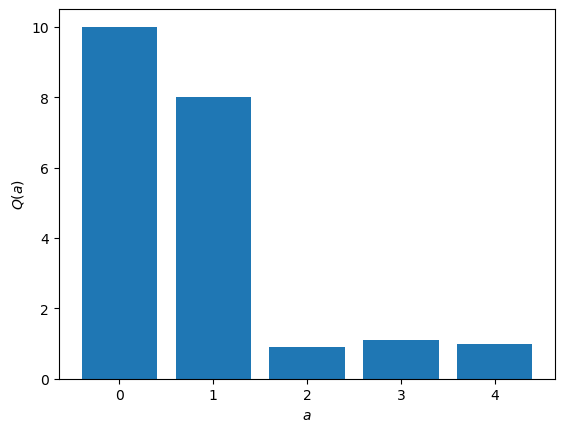

In [37]:
Q = np.array([10., 8., 0.9, 1.1, 1.])
plt.bar(range(len(Q)), Q)
plt.xlabel('$a$')
plt.ylabel('$Q(a)$')
plt.show()

Softmax probabilities for $\tau = 2$

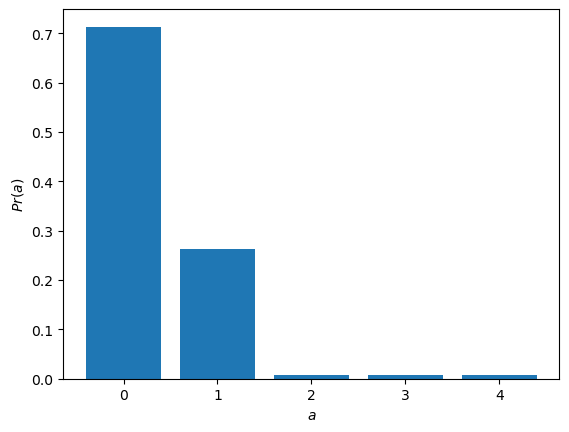

In [94]:
plt.bar(range(len(Q)), boltzmann_distribution(Q, tau=2.))
plt.xlabel('$a$'); plt.ylabel('$Pr(a)$')
plt.show()

Softmax probabilities for $\tau = 10$

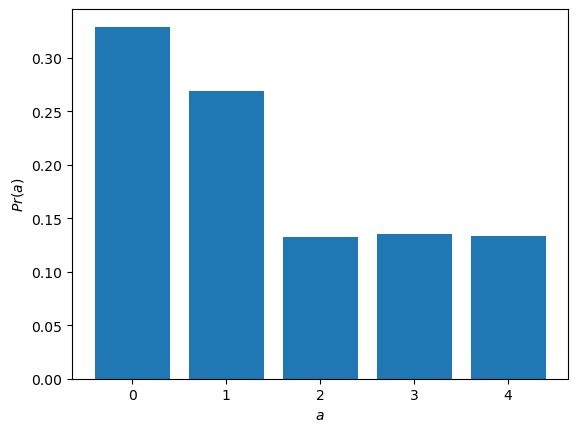

In [39]:
plt.bar(range(len(Q)), boltzmann_distribution(Q, tau=10.))
plt.xlabel('$a$'); plt.ylabel('$Pr(a)$')
plt.show()

Softmax probabilities for $\tau = 100$: it becomes flatter and flatter, more like uniform distribution, actions are all equiprobable

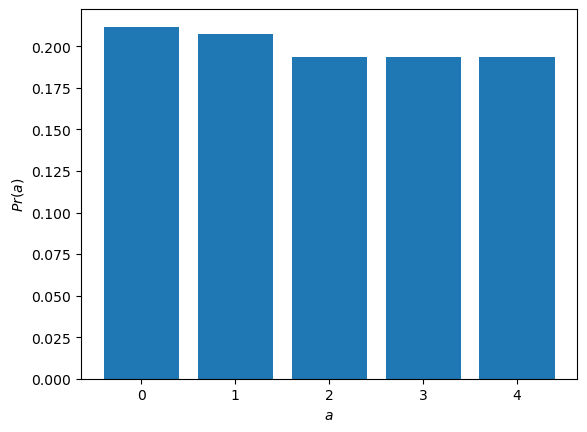

In [95]:
Q = np.array([10., 8., 1., 1., 1.])
plt.bar(range(len(Q)), boltzmann_distribution(Q, tau=100.))
plt.xlabel('$a$'); plt.ylabel('$Pr(a)$')
plt.show()

From the above figures, we can find that the probability distribution converges to be equally weighted, as $\tau \to \infty$.

## Summary
- Reinforcement-learning is an example of machine-learning.
- It can be used to solve stochastic control problems.
- We do not require a model of the environment; we can learn directly from *experience*; e.g. a realised profit/loss.
- Successful application of this technique requires careful selection of hyper-parameters.
- We should consider uncertainty and risk when selecting exploration parameters.
- So far, we have considered problems with a single state.
- We will next extend this framework to multiple states using a case-study of a simple algorithmic trading strategy.